In [51]:
from dataclasses import dataclass
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display, Image

In [52]:
class NotifyStrategy(bt.Strategy):
    def notify_order(self, order):
        pass
        # if order.status in [order.Submitted, order.Accepted]:
        #     # An order has been submitted/accepted - no need to inform
        #     return

        # if order.status in [order.Completed]:
        #     if order.isbuy():
        #         self.log(f'BUY EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm {order.executed.comm:.2f}')
        #         self.log(f'Cash Balance: {self.broker.get_cash():.2f}')
        #     elif order.issell():
        #         self.log(f'SELL EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm {order.executed.comm:.2f}')
        #         self.log(f'Cash Balance: {self.broker.get_cash():.2f}')

        # elif order.status in [order.Canceled, order.Margin, order.Rejected]:
        #     self.log('Order Canceled/Margin/Rejected')

        # # Reset orders
        # self.order = None

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')

    def get_n_shares(self, price):
        return int(self.broker.get_cash() / price)
    
    def stop(self):
        if self.position:
            self.log('Closing all positions on the last day')
            self.close()

In [53]:
class MovingAverageCrossoverStrategy(NotifyStrategy):
    """
    A simple moving average crossover strategy
    """

    params = (
        ("short_window", 3),
        ("long_window", 30),
    )

    def __init__(self):
        self.sma_short = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.short_window
        )
        self.sma_long = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.long_window
        )
        self.crossover = bt.indicators.CrossOver(self.sma_short, self.sma_long)
        self.order = None

    def next(self):
        if not self.position:  # Not currently in the market
            if self.crossover > 0:  # If the short MA crosses over the long MA
                self.order = self.buy(size=self.get_n_shares(self.data.close[0]))
        elif (
            self.crossover < 0
        ):  # In the market & the short MA crosses below the long MA
            self.order = self.sell(size=self.position.size)

        if len(self.data) == len(self.data._dataname):
            self.sell(size=self.position.size)


class BollingerBandsStrategy(NotifyStrategy):
    """
    A simple Bollinger Bands strategy

    Parameters:
        period (int): The period to be used for the Bollinger Bands
        devfactor (float): The deviation factor for the Bollinger Bands

    """

    params = (
        ("period", 20),
        ("devfactor", 2.0),
    )

    def __init__(self):
        self.boll = bt.indicators.BollingerBands(
            self.data.close, period=self.params.period, devfactor=self.params.devfactor
        )

    def next(self):
        if not self.position:  # not in the market
            if self.data.close[0] < self.boll.lines.bot[0]:
                self.buy()  # buy at lower band
        elif self.data.close[0] > self.boll.lines.top[0]:
            self.sell()  # sell at upper band


class PairTradingStrategy(NotifyStrategy):
    """
    A simple pair trading strategy

    Parameters:
        window_size (int): The lookback period for the zscore calculation
        zscore_low (float): The buy threshold (zscore)
        zscore_high (float): The sell threshold (zscore)

    """

    params = (
        ("window_size", 60),
        ("zscore_low", -2.0),
        ("zscore_high", 2.0),
    )

    def __init__(self):
        self.spread = self.datas[0].close - self.datas[1].close
        self.zscore = bt.indicators.ZScore(self.spread, period=self.params.window_size)

    def next(self):
        if self.zscore[0] > self.params.zscore_high and not self.position:
            self.sell(data=self.datas[0])  # sell the outperformer
            self.buy(data=self.datas[1])  # buy the underperformer
        elif self.zscore[0] < self.params.zscore_low and not self.position:
            self.buy(data=self.datas[0])  # buy the outperformer
            self.sell(data=self.datas[1])  # sell the underperformer
        elif abs(self.zscore[0]) < 1.0 and self.position:
            self.close(data=self.datas[0])  # close the position in first data
            self.close(data=self.datas[1])  # close the position in second data


class RSIStrategy(NotifyStrategy):
    """
    A simple RSI strategy

    Parameters:
        period (int): The period to be used for the RSI
        upper (int): The upper RSI threshold for selling
        lower (int): The lower RSI threshold for buying

    """

    params = (
        ("period", 14),
        ("upper", 70),
        ("lower", 30),
    )

    def __init__(self, params):
        self.rsi = bt.indicators.RSI(self.data.close, period=self.params.period)
        self.params = params

    def next(self):
        if not self.position:
            if self.rsi < self.params.lower:
                self.buy()  # buy signal
        elif self.rsi > self.params.upper:
            self.sell()  # sell signal


class BuyAndHoldStrategy(NotifyStrategy):
    """
    A simple Buy and Hold strategy
    """

    def start(self):
        self.order = None

    def next(self):
        # check if we can buy based on the available cash and the current price
        n_shares_to_buy = self.get_n_shares(self.data.close[0])
        if n_shares_to_buy > 0:
            self.order = self.buy(size=n_shares_to_buy)
        if len(self.data) == len(self.data._dataname):
            self.sell(size=self.position.size)

In [64]:
def run_strategy(strategy, datafeeds, cash, opt_params=None):
    cerebro = bt.Cerebro()
    for datafeed in datafeeds:
        cerebro.adddata(datafeed)
    cerebro.broker.set_cash(cash)

    if opt_params:
        cerebro.optstrategy(strategy, **opt_params)
    else:
        cerebro.addstrategy(strategy)

    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="time_return")
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe")

    print(f"Running Strategy: {strategy.__name__}")
    results = cerebro.run(maxcpus=1)
    print(f"Starting Portfolio Value: {cerebro.broker.getvalue():.2f}")

    if opt_params:
        results = get_optimizer_results(results, cash)

    time_returns = results[0].analyzers.time_return.get_analysis()
    dates = list(time_returns.keys())
    values = list(time_returns.values())
    cumulative_values = []
    running_value = cash
    for v in values:
        running_value *= (1 + v)
        cumulative_values.append(running_value)

    print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")
    print(f"Percent change: {100*(cerebro.broker.getvalue() - cash)/cash:.2f}%")
    print()

    return pd.DataFrame({'date': dates, 'value': values, 'cumulative_value': cumulative_values})


def get_optimizer_results(results, cash):
    if results is None:
        print("No results to optimize")
        return None
    best_results = None
    highest_value = 0
    # Iterate over each run's results (each run can contain multiple strategy instances due to parallel execution)
    for opt_returns in results:
        for opt_return in opt_returns:  # Each opt_return is a strategy instance
            time_returns = opt_return.analyzers.time_return.get_analysis()
            values = list(time_returns.values())
            cumulative_values = []
            running_value = cash
            for v in values:
                running_value *= (1 + v)
                cumulative_values.append(running_value)
                
            if best_results is None:
                best_results = opt_returns
                highest_value = cumulative_values[-1]
            elif cumulative_values[-1] > highest_value:
                best_results = opt_returns
                highest_value = cumulative_values[-1]
    
    if best_results is None:
        print("No results to optimize")
        return None
    print(f"Best Parameters: {best_results[0].params.__dict__}")
    return best_results

In [65]:
def get_datafeed(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    data.index = pd.to_datetime(data.index)
    datafeed = bt.feeds.PandasData(dataname=data)
    print(f"Start date: {start_date}")
    print(f"End date: {end_date}")

    start_price = data[start_date:].head(1).Open.values[0]
    end_price = data[:end_date].tail(1).Close.values[0]

    print(f"Start price: {start_price}")
    print(f"End price: {end_price}")
    print(f"Return: {100*(end_price-start_price)/start_price:.2f}%")

    return datafeed

In [66]:
def get_datafeed_dict(symbols, start_date, end_date):
    datafeeds = {}
    for symbol in symbols:
        datafeeds[symbol] = get_datafeed(symbol, start_date, end_date)
    return datafeeds

In [67]:
MovingAverageCrossoverStrategy

__main__.MovingAverageCrossoverStrategy

In [68]:
end_date = datetime.now()
start_date = end_date - timedelta(days=10*365)
starting_cash = 50000

symbols = [
    "USO",
    "VOO" 
]
datafeed = get_datafeed_dict(symbols, start_date, end_date)

crossover_params = {
    'short_window': np.arange(1, 30, 5),
    'long_window': np.arange(30, 100, 10)
}
crossover_oil_df = run_strategy(MovingAverageCrossoverStrategy, datafeed["USO"], cash=starting_cash, opt_params=crossover_params)
hold_oil_df = run_strategy(BuyAndHoldStrategy, datafeed["USO"], cash=starting_cash)
hold_voo_df = run_strategy(BuyAndHoldStrategy, datafeed["VOO"], cash=starting_cash)

strategy_dict = {
    "Crossover Oil": crossover_oil_df,
    "Hold Oil": hold_oil_df,
    "Hold VOO": hold_voo_df
}

[*********************100%%**********************]  1 of 1 completed


Start date: 2014-05-15 19:47:34.227020
End date: 2024-05-12 19:47:34.227020
Start price: 296.8800048828125
End price: 75.30000305175781
Return: -74.64%


[*********************100%%**********************]  1 of 1 completed

Start date: 2014-05-15 19:47:34.227020
End date: 2024-05-12 19:47:34.227020
Start price: 171.8000030517578
End price: 478.739990234375
Return: 178.66%
Running Strategy: MovingAverageCrossoverStrategy
Starting Portfolio Value: 50000.00
No results to optimize


TypeError: 'NoneType' object is not subscriptable

In [ ]:
datafeed["USO"]

In [ ]:
def plot_results(dfs: dict[str, pd.DataFrame]):
    plt.figure(figsize=(20, 5))
    for key, df in dfs.items():
        plt.plot(df.date, df.cumulative_value, label=key)
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    for key, df in dfs.items():
        df["percent_return"] = df.cumulative_value / df.cumulative_value[0] - 1
    
    f = plt.figure(figsize=(20, 5))
    for key, df in dfs.items():
        plt.plot(df.date, df.percent_return, label=key)
    plt.title('Percent Return Over Time')
    plt.xlabel('Date')
    plt.ylabel('Percent Return')
    plt.legend()
    plt.grid(True)
    plt.show()

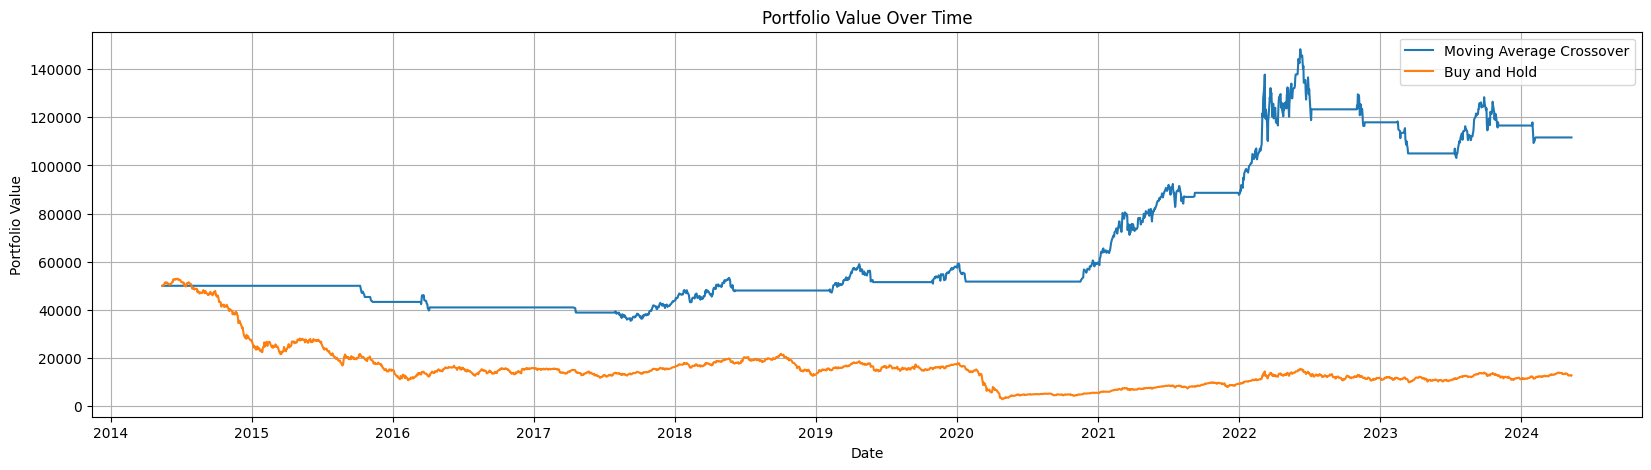

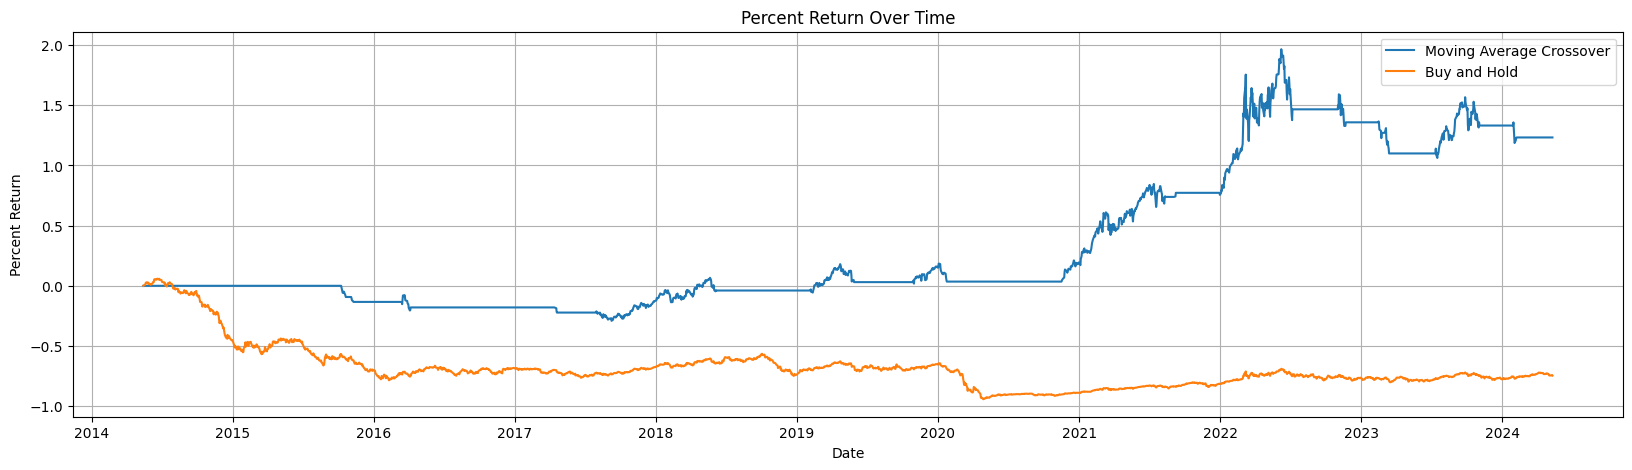

In [ ]:
plot_results(strategy_dict)